# PRAD : Analysis between risk-groups 

# Introduction

We will find the differentially expressed genes between predicted high and low risk groups. 

# Preparing workspace

In [17]:
setwd("/home/data/project_code/landstrom_core/prognostic_model_development/r/notebooks")
library(ggplot2)
library(tidyverse)
library(survival)
library(survminer)
library(glmnet)
library(WriteXLS)
library(ggfortify)
library(circlize)
library(ComplexHeatmap)
library(parallel)
library(survcomp)
library(survivalROC)
library(broom)
library(gridExtra)
library(forcats)
library(cowplot)
library(ggbreak)
library(patchwork)
library(purrr)
source("../getTCGAData.R")
source("../preprocessTCGAData.R")
source("../KM_analysis.R")
source("../Heatmaps.R")
source("../enet.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/


In [1]:
# Define the cancer type 
cancer.type = "PRAD"

In [10]:
# Read in the table including the clinical features for each cancer type
clin.feat.tb = read.table("/lustre/projects/landstrom_core/data/clin_features_final.csv", sep = "\t", header = T)

# Get Clinical variables
clin.var = unlist(strsplit(clin.feat.tb$Features[clin.feat.tb$Ctype == cancer.type], split = ","))

# Ensembl id mapping file 
ens.id.mapping = "/home/organisms/Human/hg38/Homo_sapiens.GRCh38_March2022/ENSEMBLE_to_SYMBOL.csv"

# Output dir 
out.dir.data = file.path("/lustre/projects/landstrom_core/data/fromWorkstation2_050224/rdata/manuscript_work/", cancer.type)

# 
dir.res.root.progmodel = file.path("/lustre/projects/landstrom_core/results/fromWorkstation2_050224/prognostic_model_development/models_by_cancer_type/", cancer.type)

Define and create output directories 

In [3]:
# Define and create the root directory for results 
dir.res.root = file.path("/lustre/projects/landstrom_core/results/PRAD_specific_analysis_revised/DE_by_predicted_risk", cancer.type)
dir.create(dir.res.root, recursive = T)

Warning message in dir.create(dir.res.root, recursive = T):
“'/lustre/projects/landstrom_core/results/PRAD_specific_analysis_revised/DE_by_predicted_risk/PRAD' already exists”


Read in the gene list of interest including the customer genes

In [4]:
# Gene list  
gene.list.file = read.table("/lustre/projects/landstrom_core/data/Customer_genes.tsv", 
                            sep = "\t", header = F)
gene.list = gene.list.file$V1

Read in the merged dataset and stored significant features 

In [5]:
list.files(out.dir.data)

[1] "clinical_data.csv"                  "copy_number_status.rds"            
[3] "processed_exp_data.rds"             "raw_expressions.rds"               
[5] "tcga.dataset_merged.rds"            "tcga.dataset_splitted.rds"         
[7] "tcga.dataset.rds"                   "variables_selected_filtered_ls.rds"

In [13]:
tcga.dataset.merged = readRDS(file.path(out.dir.data, "tcga.dataset_merged.rds"))
significant.features.ls = readRDS(file.path(dir.res.root.progmodel, "significant.features.ls"))

# Fit the model with clinical variables

In [20]:
dir.res.pcox = file.path(dir.res.root, "Penalized_Cox_risk_prediction/customer_features/With_clinical_features")
dir.create(dir.res.pcox, recursive = T)

In [21]:
# Store significant features 
rcox.res.with.clin.ls = list()

# Store model matrices
model.matrices.ls = list()

# Store the fitted models for prediction 
pcox.fit.ls = list()

In [22]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # Construct the clinical end points 
    end_point_event = paste0(end.point, ".clin")
    end_point_time = paste0(end.point, ".time.clin")
    
    # Clinical features
    clinical.feat = paste0(clin.var, ".clin")
    
    # Subset 
    selected.features = c(end_point_event, end_point_time, clinical.feat, significant.features.ls[[end.point]])
    
    # Input training data 
    input.training = tcga.dataset.merged[[end.point]]$train %>% dplyr::select(all_of(selected.features))
    input.validation = tcga.dataset.merged[[end.point]]$validation %>% dplyr::select(all_of(selected.features))
    
    # Check the number of features
    # Regulariation cannot be run if there is only one feature
    num.feat = ncol(input.training) - 2
    
    if (is.null(tcga.dataset.merged[[end.point]]$train) == F){
        if (num.feat > 1) {
    
            # Genereate model matrix 
            model.matrices = generateModelMatrices(input.training, 
                                                   input.validation, 
                                                   clinical.endpoint = end.point)          
        
            model.matrices.ls[[end.point]] = model.matrices
    
            # Create output dir 
            dir.create(file.path(dir.res.pcox, end.point))
    
            # Find optimal lambda (hyperparameter for elastic net)
            pcox.fit = findOptimalLambda(x = model.matrices$x.train.mat, 
                             y = model.matrices$y.train,
                             out.dir = file.path(dir.res.pcox, end.point))
        
            pcox.fit.ls[[end.point]] = pcox.fit
            
            if (is.null(pcox.fit) == F){
                # Write the final features included in the model to a file 
                WriteXLS(pcox.fit$active.k.vals, 
                     file.path(dir.res.pcox, end.point ,"Active_covariates_in_lambda.min_model.xlsx"), 
                      BoldHeaderRow = T,
                      row.names = T)           
            
                    
                # Final significant features 
                rcox.res.with.clin = pcox.fit$active.k.vals %>% tibble::rownames_to_column("Feature")
                rcox.res.with.clin.ls[[end.point]] = rcox.res.with.clin  
                
            } else {
                model.matrices.ls[[end.point]] = NULL
                pcox.fit.ls[[end.point]] = NULL
                rcox.res.with.clin.ls[[end.point]] = NULL
            
            }
            
        } else {
            # If no significant features from earlier steps for the clin. end point then store null
            model.matrices.ls[[end.point]] = NULL
            pcox.fit.ls[[end.point]] = NULL
            rcox.res.with.clin.ls[[end.point]] = NULL
        }

    } else {
        # If no significant features from earlier steps for the clin. end point then store null
        model.matrices.ls[[end.point]] = NULL
        pcox.fit.ls[[end.point]] = NULL
        rcox.res.with.clin.ls[[end.point]] = NULL
    }
}

## 4.4 Make predictions using the cross-validated model

## 4.4.1 Training set 

In [134]:
# Store the prediction results 
training.predictions.ls = list()

In [135]:
# Set seed 
set.seed(42)

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the training set
        pred.train <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.train.mat, 
                      s = "lambda.min", 
                      type = "response")
            
        training.predictions.ls[[end.point]] = pred.train
    } else {
        training.predictions.ls[[end.point]] = NULL
    }
}

## 4.4.2 Validation set

In [136]:
# Store the prediction results 
validation.predictions.ls = list()

In [137]:
# Set seed
set.seed(42)

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the validation set
        pred.valid <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.valid.mat, 
                      s = "lambda.min", 
                      type = "response")

        validation.predictions.ls[[end.point]] = pred.valid
    } else {
        validation.predictions.ls[[end.point]] = NULL
    }
}

In [82]:
dim(tcga.dataset.merged$PFI$train )

[1]   360 76306

In [83]:
dim(tcga.dataset.merged$PFI$validation)

[1]   121 76306

In [145]:
tcga.dataset.merged$PFI$train[1:5,1:5] 

,Participant.ID,submitter_id.clin,age_at_diagnosis.clin,site_of_resection_or_biopsy.clin,ajcc_pathologic_t.clin
,<chr>,<chr>,<int>,<chr>,<chr>
1,TCGA-EJ-7789,TCGA-EJ-7789,24107,Prostate gland,T3a
2,TCGA-KK-A8IB,TCGA-KK-A8IB,24041,Prostate gland,T3a
3,TCGA-EJ-7125,TCGA-EJ-7125,16425,Prostate gland,T2c
4,TCGA-CH-5741,TCGA-CH-5741,20759,Prostate gland,T3b
5,TCGA-HC-7210,TCGA-HC-7210,27343,Prostate gland,T2a


# 5. Divide patients based on the predicted risk and run DE analysis

Read in raw data

In [53]:
tcga.expr.raw.datamat = readRDS(file.path(out.dir.data, "raw_expressions.rds"))

Outdir

In [54]:
out.dir = dir.res.root

In [55]:
library(DESeq2)

In [95]:
predicted.risks.full = list()

In [96]:
for (end.point in c("OS","DSS","DFI","PFI")){
    
    predicted.risks.full[[end.point]] = list("Risks" = NULL, 
                                             "Median.risk" = NULL,
                                             "Groups" = list("High.risk" = NULL , 
                                                             "Low.risk" = NULL))
     
    valid.risk = validation.predictions.ls[[end.point]]
    train.risk = training.predictions.ls[[end.point]]
    
    if (!is.null(valid.risk)){
    
        # Merge the predicted risk
        predicted.risks.full[[end.point]][["Risks"]] = rbind(train.risk, valid.risk)
        rownames(predicted.risks.full[[end.point]][["Risks"]]) = NULL
    
        # Calculate median risk
        median.risk = median(predicted.risks.full[[end.point]][["Risks"]][,1]) 
        predicted.risks.full[[end.point]][["Median.risk"]] = median.risk
        
        # Groups 
        high.group.idx = which(predicted.risks.full[[end.point]][["Risks"]] > median.risk)
        low.group.idx =  which(predicted.risks.full[[end.point]][["Risks"]] <= median.risk)
        predicted.risks.full[[end.point]][["Groups"]][["High.risk"]] = high.group.idx
        predicted.risks.full[[end.point]][["Groups"]][["Low.risk"]] = low.group.idx
    
    }
}

Prepare the raw data 

In [99]:
# Preprocess raw data
raw.data = tcga.expr.raw.datamat
colnames(raw.data ) = map_chr(colnames(raw.data), sampleToParticipantID)
rownames(raw.data) = paste0(rownames(raw.data), ".exp")

In [150]:
# Store final raw data expression matrices 
raw.data.final = list()
metadata = list()

In [151]:
# Iterate over end points and produce final raw data expression matrices
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # Find the subset of samples to be selected 
    high.risk.group = predicted.risks.full[[end.point]][["Groups"]][["High.risk"]]
    low.risk.group = predicted.risks.full[[end.point]][["Groups"]][["Low.risk"]]
    
    if (!is.null(high.risk.group)){
        
        # Prepare final raw data for DESeq2 
        #raw.data.final[[end.point]] = raw.data[,c(high.risk.group, low.risk.group)] 
        samples.cohort = c(tcga.dataset.merged$PFI$train$Participant.ID, tcga.dataset.merged$PFI$validation$Participant.ID)
        
    
        # Prepare sample metadata for DESeq2
        high.risk.group.df = data.frame("Condition" = rep("High.risk", length(high.risk.group )))
        rownames(high.risk.group.df) = samples.cohort[high.risk.group]
    
        low.risk.group.df = data.frame("Condition" = rep("Low.risk", length(low.risk.group )))
        rownames(low.risk.group.df) = samples.cohort[low.risk.group]
    
        metadata[[end.point]] = rbind(low.risk.group.df, high.risk.group.df) 
        
        raw.data.final[[end.point]] = raw.data[,match(rownames(metadata[[end.point]]), colnames(raw.data)) ]
    }
}

TESTING

In [154]:
raw.data.final.pfi.test = raw.data.final$PFI %>% tibble::rownames_to_column("Gene") %>% pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

In [155]:
metadata.pfi.test = metadata$PFI %>% tibble::rownames_to_column("Sample") 

In [156]:
raw.data.final.pfi.test.merge = dplyr::left_join(raw.data.final.pfi.test, metadata.pfi.test, by = "Sample")

In [166]:
kif23.test = raw.data.final.pfi.test.merge %>% dplyr::filter(Gene == "AURKB.exp")

In [167]:
head(kif23.test)

Gene,Sample,Expression,Condition
<chr>,<chr>,<dbl>,<chr>
AURKB.exp,TCGA-EJ-7125,99,Low.risk
AURKB.exp,TCGA-HC-7210,43,Low.risk
AURKB.exp,TCGA-EJ-5542,75,Low.risk
AURKB.exp,TCGA-M7-A721,86,Low.risk
AURKB.exp,TCGA-V1-A8WL,44,Low.risk
AURKB.exp,TCGA-J4-A67M,42,Low.risk


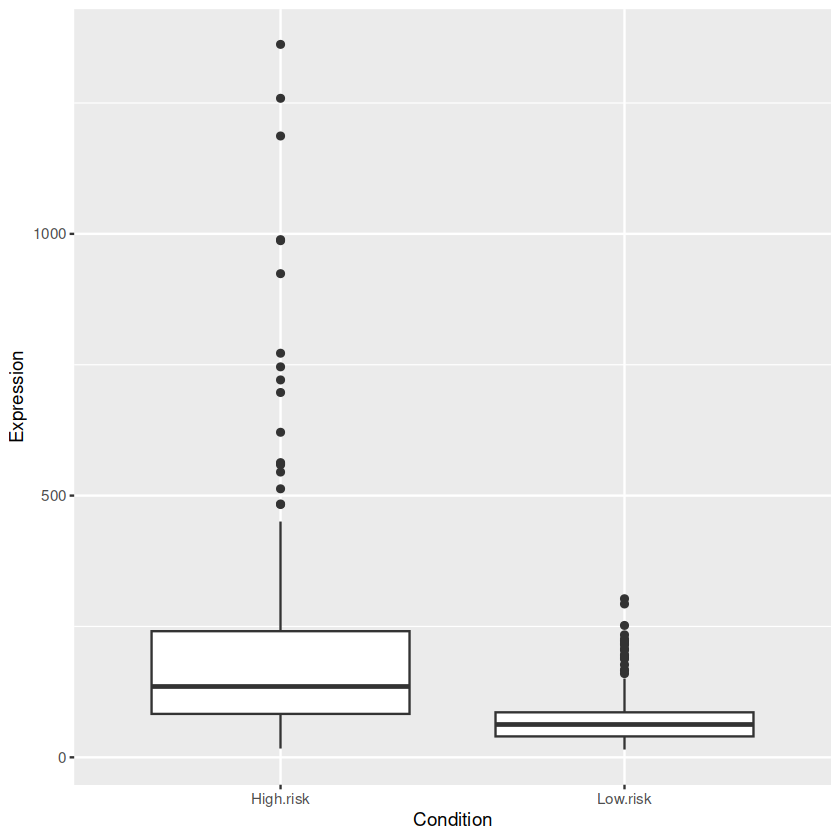

In [198]:
kif23.test %>% ggplot(aes(x = Condition ,y = Expression)) + geom_boxplot()

In [199]:
# Iterate over end points and produce final raw data expression matrices
for (end.point in c("DSS","DFI","PFI")){
    
    if (!is.null(metadata[[end.point]])){
        
        # Get the data  
        count.data = raw.data.final[[end.point]] 
        coldata = metadata[[end.point]] 
        
        # Process 
        coldata$Condition = factor(coldata$Condition, levels = c("Low.risk","High.risk"))
        count.data = count.data[,match(rownames(coldata), colnames(count.data))]
        
        # Fix the gene names
        rownames(count.data) = str_remove(rownames(count.data), "\\.exp")
        

        
        # Generate DESeq2 object  
        dds <- DESeqDataSetFromMatrix(countData = count.data,
                              colData = coldata,
                              design = ~ Condition)
        
        # Filter some low expressing genes 
        keep <- rowSums(counts(dds)) >= 10
        dds <- dds[keep,]
        
        # DE analysis
        dds <- DESeq(dds)
        
        # Get DE results 
        de.results = as.data.frame(results(dds, lfcThreshold = 0.5))
        
        # Arrange by P-value 
        de.results = de.results %>% 
                           arrange(padj)
        
        # Write results to csv 
        write.csv(de.results, file.path(out.dir, paste0(end.point, "_by_risk_de_results_lfc_05.csv")))
        
    }  
}   

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3564 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3368 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testin

# 6. Prepare a volcano plot 

In [200]:
# Read in results
pfi.de.results = read.csv(file.path(out.dir, "PFI_by_risk_de_results_lfc_05.csv"))

In [201]:
pfi.de.results$Symbol = pfi.de.results$X

In [202]:
pfi.de.results = pfi.de.results[!(is.na(pfi.de.results$padj)),]

In [203]:
# Determine which are significant 
pfi.de.results$Significant = ifelse(pfi.de.results$padj < 0.05 , "yes", "no")

In [204]:
table(pfi.de.results$Significant)


   no   yes 
37333   785 

In [205]:
# Prepare a list of genes to highlight 
highlight.genes = gene.list

In [206]:
pfi.de.volcano.plot = ggplot(pfi.de.results, aes(x = log2FoldChange, 
                                                 y = -1 * log10(pvalue),
                                                 colour = Significant)) + 
                             geom_point() + 
                             scale_color_manual(values = c("yes" = "red", "no" = "#424242")) +
                             #geom_text(data = subset(pfi.de.results, Symbol %in% highlight.genes), aes(label = Symbol), hjust = 0, nudge_x = 0.05) + 
                             theme_bw() + xlim(-4,4) 


Warning message:
“Removed 2 rows containing missing values (geom_point).”


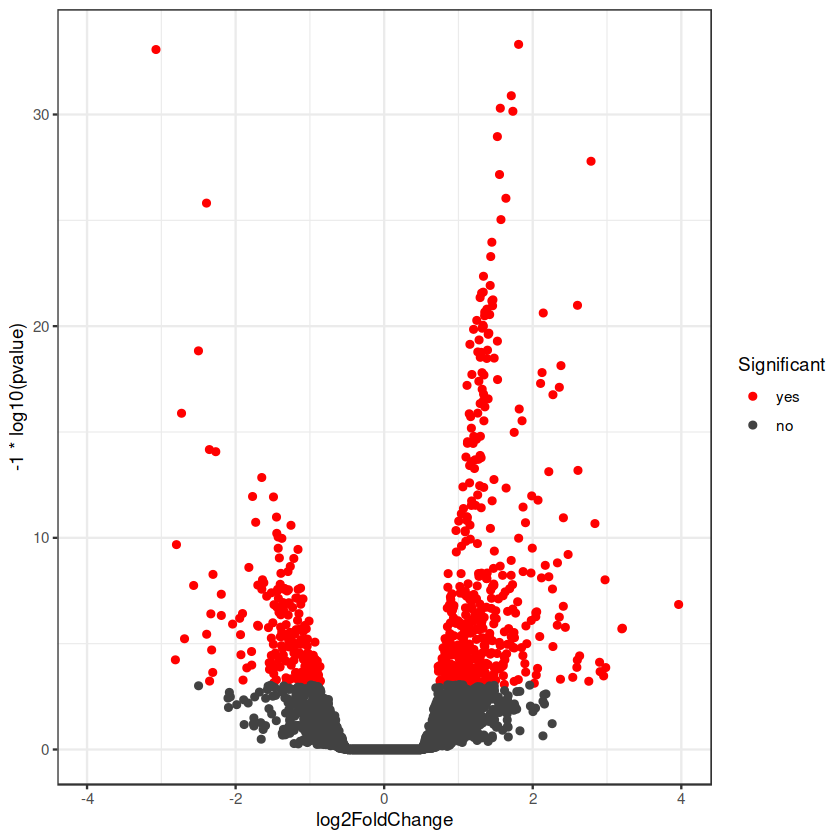

In [15]:
pfi.de.volcano.plot

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


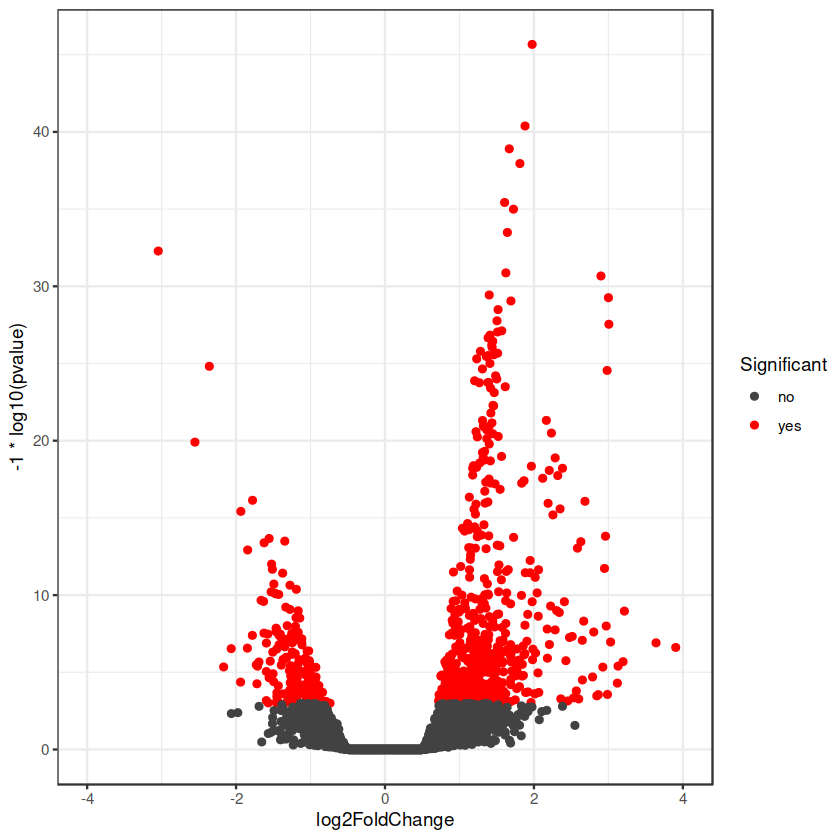

In [207]:
pfi.de.volcano.plot

In [208]:
ggsave(file.path(out.dir, "PFI_DE_volcanoplot.pdf"), plot = pfi.de.volcano.plot , width = 8, height = 10)

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


In [209]:
library(ggrepel)

In [210]:
pfi.de.results.selected = pfi.de.results %>% filter(X %in% c("KIF23","AURKA","AURKB", "PTEN"))

In [211]:
annotations.df = data.frame(Gene = pfi.de.results.selected$X,
                            x = pfi.de.results.selected$log2FoldChange,
                            x_end = 0,
                            y = -1 * log10(pfi.de.results.selected$pvalue),
                            y_end = -1 * log10(pfi.de.results.selected$pvalue) + 5)

In [212]:
annotations.df

Gene,x,x_end,y,y_end
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AURKB,1.5036278,0,27.76381,32.76381
KIF23,1.1885004,0,18.38008,23.38008
AURKA,1.0165055,0,11.85322,16.85322
PTEN,-0.3774717,0,0.00000,5.00000


In [213]:
pfi.de.volcano.plot.with.lab = ggplot(pfi.de.results, aes(x = log2FoldChange, 
                                                 y = -1 * log10(pvalue),
                                                 colour = Significant)) + 
                             geom_point() + 
                             scale_color_manual(values = c("yes" = "red", "no" = "#424242")) +
                             theme_bw() + xlim(-4,4) +
               geom_text(data = annotations.df, aes(x = x_end, y = y_end,label = Gene), colour = "black") +
               geom_segment(data = annotations.df, aes(x = x, xend = x_end, y = y, yend = y_end), colour = "black")

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


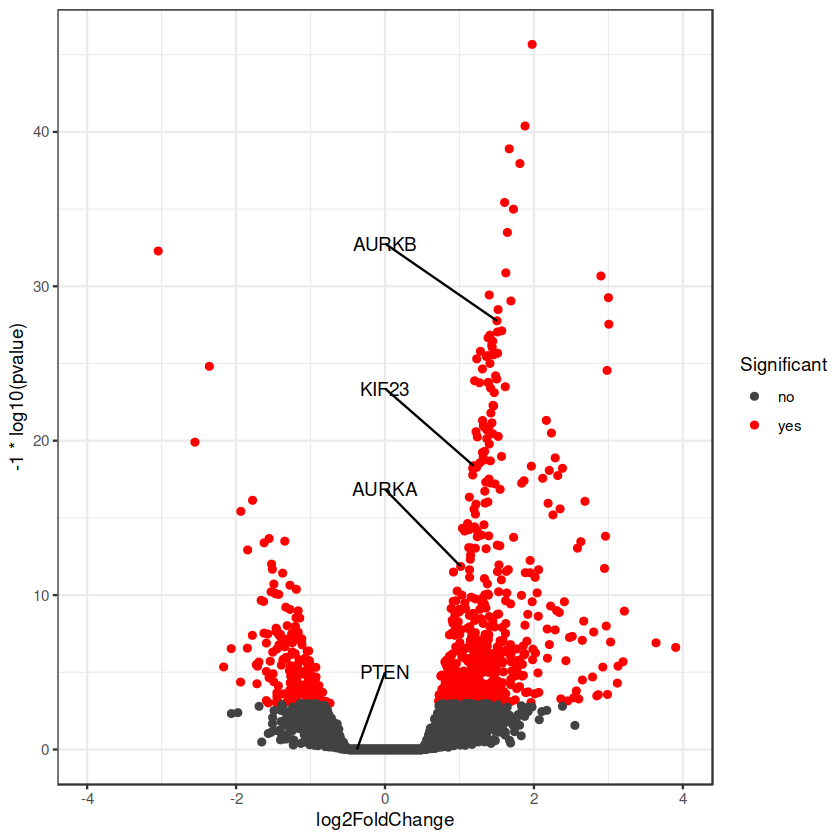

In [214]:
pfi.de.volcano.plot.with.lab 

In [215]:
ggsave(file.path(out.dir, "PFI_DE_volcanoplot_with_lab.pdf"), plot = pfi.de.volcano.plot.with.lab , width = 8, height = 10)

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


In [216]:
pfi.de.results.selected.2 = pfi.de.results %>% filter(X %in% c("KIF23","AURKA","AURKB", "PTEN", "BIRC5", "KIF2C", "CDCA8", "TPX2"))

In [217]:
annotations.df = data.frame(Gene = pfi.de.results.selected.2$X,
                            x = pfi.de.results.selected.2$log2FoldChange,
                            x_end = 0,
                            y = -1 * log10(pfi.de.results.selected.2$pvalue),
                            y_end = -1 * log10(pfi.de.results.selected.2$pvalue) + 5)

In [218]:
annotations.df

Gene,x,x_end,y,y_end
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BIRC5,1.6429893,0,33.487426,38.48743
AURKB,1.5036278,0,27.763811,32.76381
TPX2,1.4464440,0,26.447188,31.44719
KIF2C,1.2682308,0,23.752066,28.75207
KIF23,1.1885004,0,18.380081,23.38008
AURKA,1.0165055,0,11.853216,16.85322
CDCA8,0.9023817,0,8.366553,13.36655
PTEN,-0.3774717,0,0.000000,5.00000


In [219]:
pfi.de.volcano.plot.with.lab.2 = ggplot(pfi.de.results, aes(x = log2FoldChange, 
                                                 y = -1 * log10(pvalue),
                                                 colour = Significant)) + 
                             geom_point() + 
                             scale_color_manual(values = c("yes" = "red", "no" = "#424242")) +
                             theme_bw() + xlim(-4,4) +
               geom_text(data = annotations.df, aes(x = x_end, y = y_end,label = Gene), colour = "black") +
               geom_segment(data = annotations.df, aes(x = x, xend = x_end, y = y, yend = y_end), colour = "black")

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


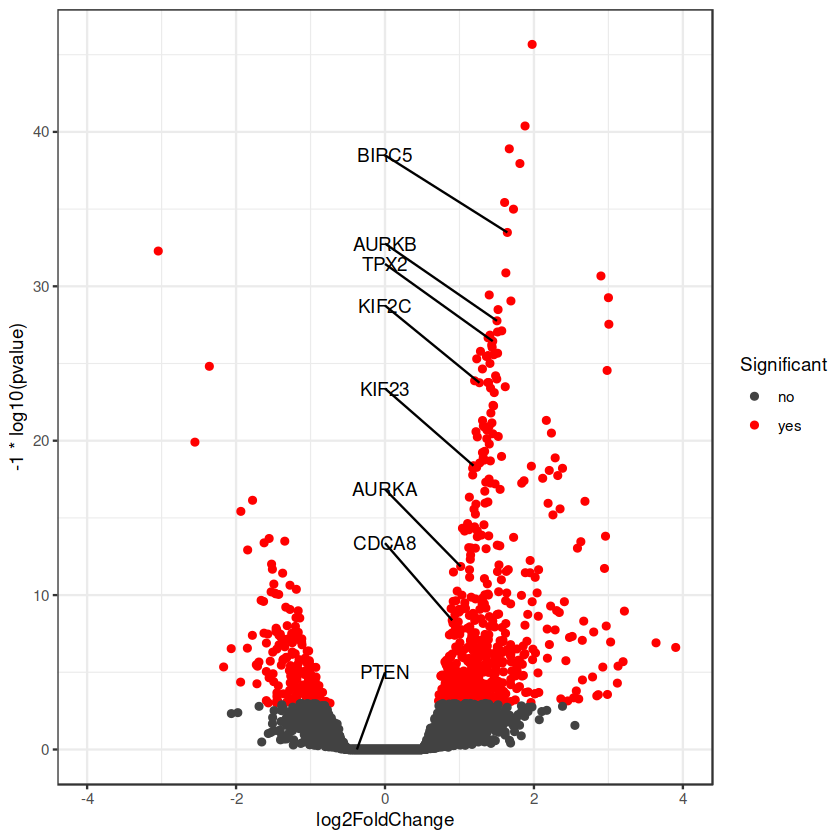

In [220]:
pfi.de.volcano.plot.with.lab.2 

In [221]:
ggsave(file.path(out.dir, "PFI_DE_volcanoplot_with_lab.2.pdf"), plot = pfi.de.volcano.plot.with.lab.2 , width = 8, height = 10)

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


In [222]:
# Save volcano input to RDS 
saveRDS(pfi.de.results, file.path(out.dir, "PFI_volcano_input.rds"))

# 7. Pathway enrichment analysis

## 7.1 ORA 

In [223]:
library(clusterProfiler)
library(ReactomePA)

Functions

In [224]:
#
# Function for converting gene symbols to entrez ids 
#
symbolToEntrez = function(x){
    res = bitr(x, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
    colnames(res) = c("Feature", "ENTREZID")
    return(res)
}

#
# Function for running Overrepresentation analysis against Reactome database 
#
runORAReactome = function(table){
    
    # Extract the Entrez ids 
    sig.genes = table$ENTREZID
    
    # Run ORA
    enriched.pathways = enrichPathway(gene=sig.genes, 
                                      readable=TRUE)
    # Return full results
    return(enriched.pathways)
    
}

Read in the DE results

In [225]:
# Read 
de.results.tables = map(list.files(path = out.dir, pattern = ".csv", full.names = T) ,read.csv)

# Assign names 
splits = strsplit(list.files(path = out.dir, pattern = ".csv"), "_")
names(de.results.tables) = map_chr(splits, function(x){x[1]})

In [226]:
# Store results
ora.reactome.ls = list()
ora.obj.ls = list()
logFC.ls = list()

In [230]:
names(de.results.tables)

[1] "DFI" "DSS" "PFI"

In [234]:
for (end.point in names(de.results.tables)){
    
    # DE results
    de.table = de.results.tables[[end.point]]

    # Find significant DE genes 
    diff.genes = de.table %>% 
                    dplyr::filter(padj < 0.05, baseMean >= 20) 

    if (nrow(diff.genes) > 0) {
        diff.genes.symbol = as.vector(diff.genes$X)
        log.fc = diff.genes$log2FoldChange
        names(log.fc) = diff.genes$X
        logFC.ls[[end.point]] = log.fc
    
        # Map symbols to entrez ids 
        mapped.symbols = symbolToEntrez(diff.genes.symbol)
    
        # Run ORA
        ora.results.obj = runORAReactome(mapped.symbols)
        ora.obj.ls[[end.point]] = ora.results.obj
        ora.results = ora.results.obj@result
        ora.reactome.ls[[end.point]] = ora.results
    }
    
}

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“12.5% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(x, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“5.8% of input gene IDs are fail to map...”


Write results 

In [235]:
for (end.point in names(ora.reactome.ls)){
    write.csv(ora.reactome.ls[[end.point]], file.path(out.dir, paste0(end.point, "_reactome_pathway_enrichment.csv")))
}

Check TGFbeta genes in the enriched pathways

In [236]:
tgf_beta_genes = read.csv("/lustre/projects/landstrom_core/data/TGFBeta_genes.csv")

In [237]:
goi = unique(c(tgf_beta_genes$Gene, gene.list))

In [238]:
# TEST if gene in in pathway
geneInPath = function(genes.in.path, goi){
    genes.in.path.ls = unlist(strsplit(genes.in.path, split = "/"))
    common.genes = intersect(genes.in.path.ls, goi)
    if (length(common.genes) > 0){
        return(TRUE)
    } else {
        return(FALSE)
    }
}

In [239]:
pfi.ora.signpathways = ora.reactome.ls$PFI %>% 
                                filter(p.adjust < 0.05)

In [240]:
test = map_lgl(pfi.ora.signpathways$geneID,
       geneInPath,
       goi = goi)

In [241]:
top30.pathways.pfi = pfi.ora.signpathways[1:30,]

In [242]:
top30.pathways.pfi.inc.goi = top30.pathways.pfi[test[1:30],] 

## 7.2 Visualisations 

In [243]:
library(enrichplot)


Attaching package: ‘enrichplot’


The following object is masked from ‘package:ggpubr’:

    color_palette




### 7.2.1 Dotplot

In [244]:
# Save to RDS 
saveRDS(ora.obj.ls[["PFI"]], file.path(out.dir, "PFI_ORA_dotplot_input.rds"))

In [245]:
enrichment.dotplot = dotplot(ora.obj.ls[["PFI"]], showCategory=30)

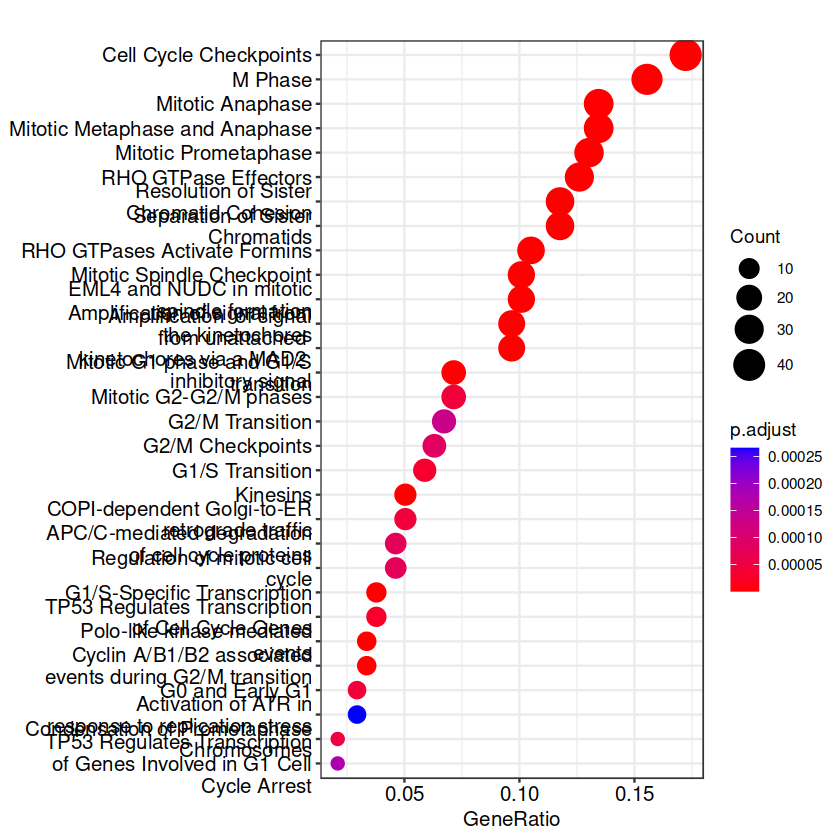

In [246]:
enrichment.dotplot

In [247]:
pdf(file.path(out.dir,"PFI_enrichment_dotplot.pdf"), width = 10, height = 14)
enrichment.dotplot  
dev.off()

png 
  2

### 7.2.2 Enrichment plot

Shows the relatioship of all enriched pathways

In [248]:
ora.obj.ls[["PFI"]] <- pairwise_termsim(ora.obj.ls[["PFI"]])

enrichment.plot <- emapplot(ora.obj.ls[["PFI"]])

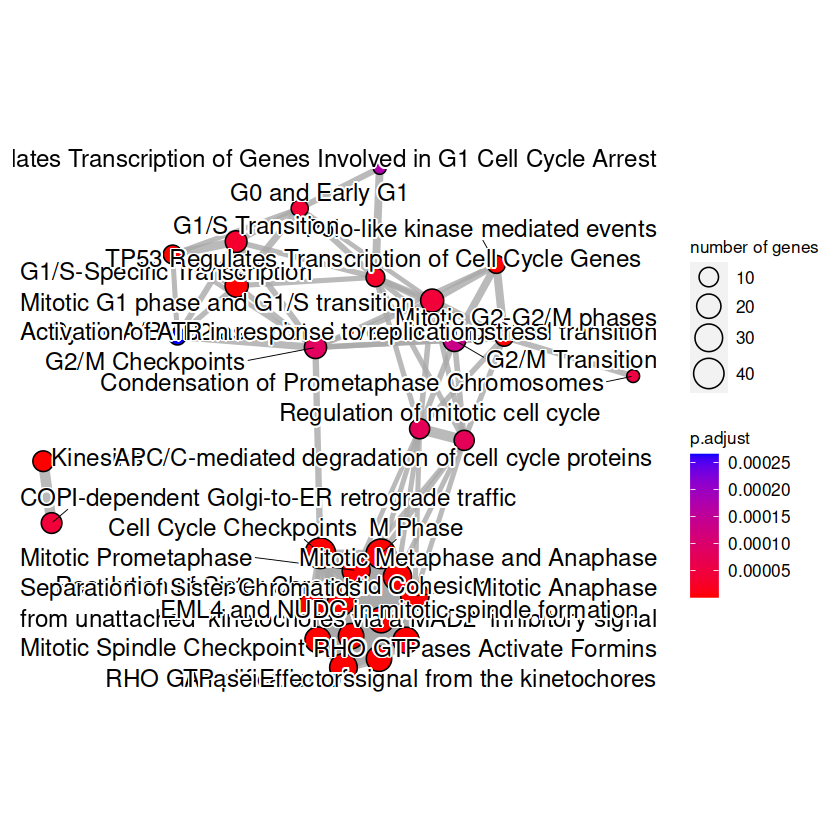

In [249]:
enrichment.plot

In [250]:
pdf(file.path(out.dir,"PFI_enrichment_plot.pdf"), width = 20, height = 20)
enrichment.plot 
dev.off()

png 
  2

Seems that the cell cycle related pathways separate as their own module

### 7.2.3 Cnet plot 

Shows the relatioship between genes and pathways. We will show those pathways in top 30 which also include GOI

In [251]:
ora.obj.ls[["PFI"]] <- setReadable(ora.obj.ls[["PFI"]], 'org.Hs.eg.db', 'ENTREZID')

In [252]:
p1 <- cnetplot(ora.obj.ls[["PFI"]], foldChange=logFC.ls[["PFI"]], 
               showCategory = top30.pathways.pfi.inc.goi$Description)

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


In [253]:
pdf(file.path(out.dir,"cnet_cell_proliferation_pathways.pdf"), width = 20, height = 20)
p1
dev.off()

png 
  2

Warning message:
“ggrepel: 42 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


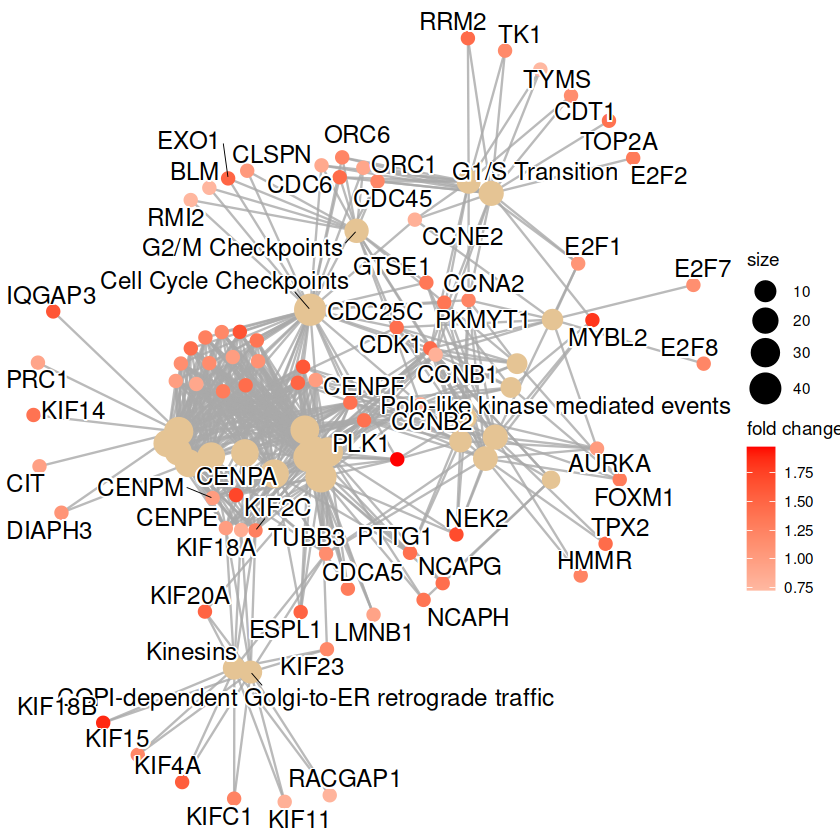

In [254]:
p1

Next we want to produce the same plot but now showing only genes of interest. We include also genes from the "extended list" meining the genes belonging to the non-canonical TGFbeta pathway.

In [259]:
# Read in original gene list 
original.genes = read.table("/lustre/projects/landstrom_core/data/Customer_genes.tsv", 
                            sep = "\t", header = F)

# Read in pathway genes
tgf_beta_genes = read.csv("/lustre/projects/landstrom_core/data/TGFBeta_genes.csv")
gene.list = c(tgf_beta_genes$Gene, original.genes$V1)

In [260]:
overlaps = function(x, y){
    genes.pathway = unlist(strsplit(x, "/"))
    intersection = intersect(genes.pathway, y)
    return(intersection)
}

findOverlapsEnr = function(enr.results.df, gene.list){
    res = map(enr.results.df$geneID, overlaps, y = gene.list )
    names(res) = enr.results.df$Description
    return(res)
}

pathway.overlaps = findOverlapsEnr(top30.pathways.pfi.inc.goi, gene.list)

In [261]:
# Find the log-fold changes for these genes 
genes = unique(unlist(pathway.overlaps))
genes.fc = logFC.ls[["PFI"]][genes]

In [262]:
p2 <- cnetplot(pathway.overlaps, foldChange = genes.fc, showCategory = 25)

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


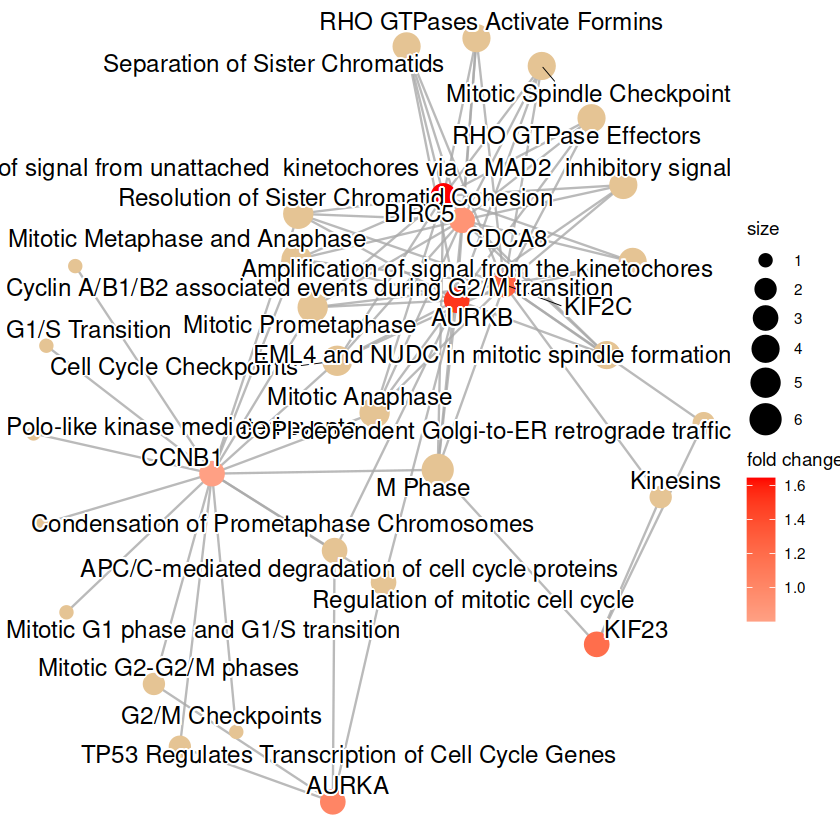

In [263]:
p2

In [264]:
pdf(file.path(out.dir,"cnet_plot_top30_with_goi.pdf"), width = 14, height = 12)
p2
dev.off()

png 
  2

Prepare a version of the above plot only including KIF23, AURKA and AURKB

In [265]:
pathway.overlaps.sig.genes = findOverlapsEnr(top30.pathways.pfi.inc.goi, c("KIF23","AURKA","AURKB"))

In [266]:
length(pathway.overlaps.sig.genes)

[1] 26

In [267]:
genes.fc.sig.genes = logFC.ls[["PFI"]][c("KIF23","AURKA","AURKB")]

In [268]:
genes.fc.sig.genes

KIF23    AURKA    AURKB 
1.188500 1.016506 1.503628

In [269]:
length(pathway.overlaps.sig.genes)

[1] 26

In [270]:
pathway.overlaps.sig.genes.final = list()
pathway.names = c()
idx = 1
for (i in 1:length(pathway.overlaps.sig.genes)){
    name = names(pathway.overlaps.sig.genes)[i]
    item = pathway.overlaps.sig.genes[[i]]

    if (identical(item, character(0)) == F){
        pathway.overlaps.sig.genes.final[[idx]] = item
        pathway.names = c(pathway.names, name)
        idx = idx + 1
    } 
}
names(pathway.overlaps.sig.genes.final) = pathway.names

In [271]:
length(pathway.overlaps.sig.genes.final)

[1] 20

In [272]:
p3 <- cnetplot(pathway.overlaps.sig.genes.final, foldChange = genes.fc.sig.genes, showCategory = 20)

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


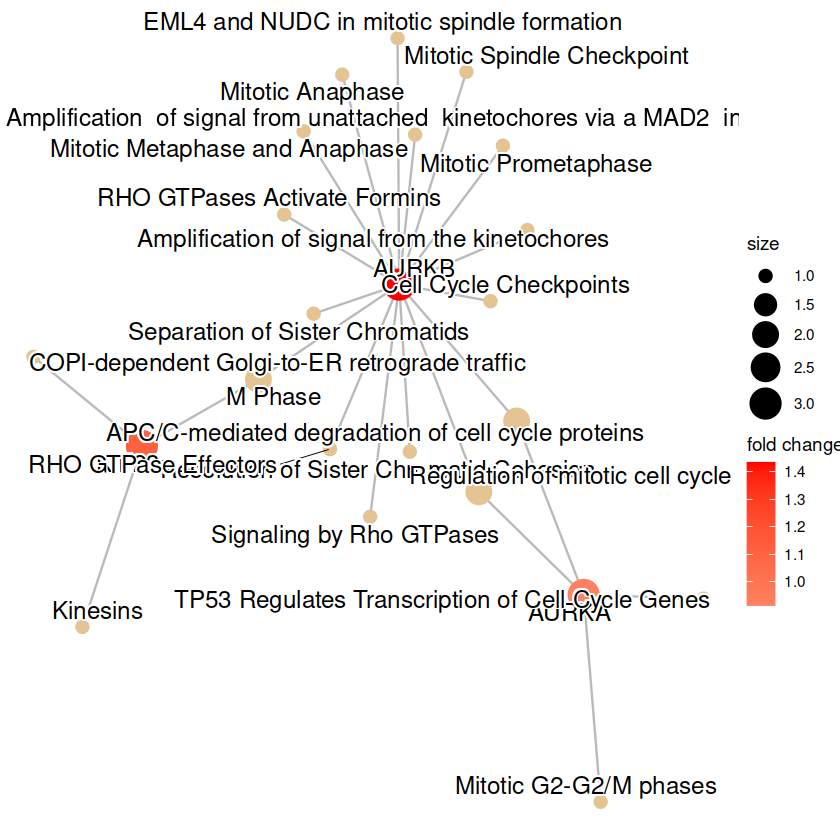

In [101]:
p3

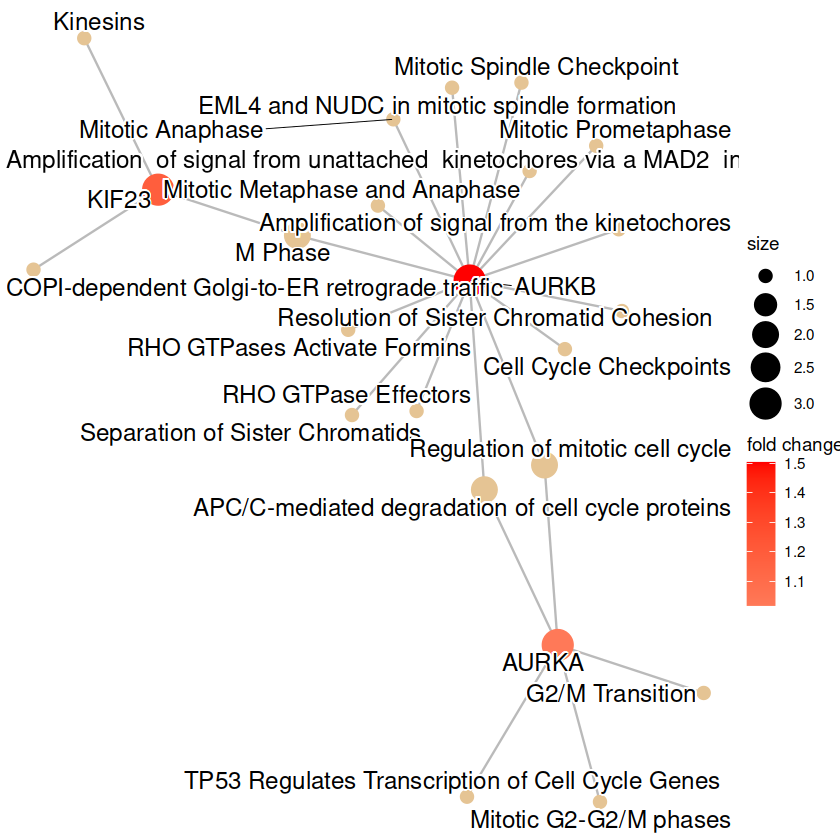

In [273]:
p3

In [274]:
pdf(file.path(out.dir,"cnet_plot_top30_with_KIF23_AURKA_AURKB.pdf"), width = 14, height = 12)
p3
dev.off()

png 
  2

In [275]:
out.dir

[1] "/lustre/projects/landstrom_core/results/PRAD_specific_analysis_revised/DE_by_predicted_risk/PRAD"

### 

### 